В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

## **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

medical_df = pd.read_csv('medical-charges.csv')  # замініть на ваш шлях до файлу
non_smoker_df = medical_df[medical_df.smoker == 'no']

non_smoker_df['charges'].describe()

count     1064.000000
mean      8434.268298
std       5993.781819
min       1121.873900
25%       3986.438700
50%       7345.405300
75%      11362.887050
max      36910.608030
Name: charges, dtype: float64

Метод найменших квадратів — це статистичний метод, використовуваний для знаходження значень параметрів $ \theta $, які мінімізують суму квадратів різниць між спостережуваними та прогнозованими значеннями залежної змінної, визначену функцією втрат. Цей метод веде до формування нормальних рівнянь:
$$ X^T X \theta = X^T y $$
де $ X $ — матриця дизайну, а $ y $ — вектор спостережуваних значень. Розв'язуючи це рівняння, можна отримати оптимальні значення $ \theta $, які мінімізують функцію втрат.

Розв'язуючи $ \theta = (X^T X)^{-1} X^T y $, ми знаходимо значення $ \theta $, які мінімізують функцію втрат $ L $, тим самим найкраще узгоджуючи лінію з даними у рамках лінійної регресії. Цей метод забезпечує пряме, закрите рішення для коефіцієнтів.

### Завдання №1.1 (за допомогою МНК)

In [180]:
def normal_equation(X, y):
    """
    X.T @ X еквівалентно X.T.dot(X).
    X.T @ X — оператор @ у Python використовується для матричного множення (починаючи з версії Python 3.5 та NumPy 1.10). Це більш сучасний і читаємий спосіб запису.
    """
    theta = np.linalg.inv(X.T @ X) @ X.T @ y  # same as np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [181]:
X = non_smoker_df.age.values.reshape(-1, 1)
X_with_intercept = np.c_[np.ones((X.shape[0], 1)), X]

y = non_smoker_df['charges'].values

# Перевіряємо розмірність матриць
print(X.shape, X_with_intercept.shape)
print(f'X\n', X[:3])
print(f'X_with_intercept \n', X_with_intercept[:3])

(1064, 1) (1064, 2)
X
 [[18]
 [28]
 [33]]
X_with_intercept 
 [[ 1. 18.]
 [ 1. 28.]
 [ 1. 33.]]


In [182]:
MNK_coefs = normal_equation(X_with_intercept, y)  # B0, B1
print(MNK_coefs)

predictions_MNK = X_with_intercept @ MNK_coefs

[-2091.42055657   267.24891283]


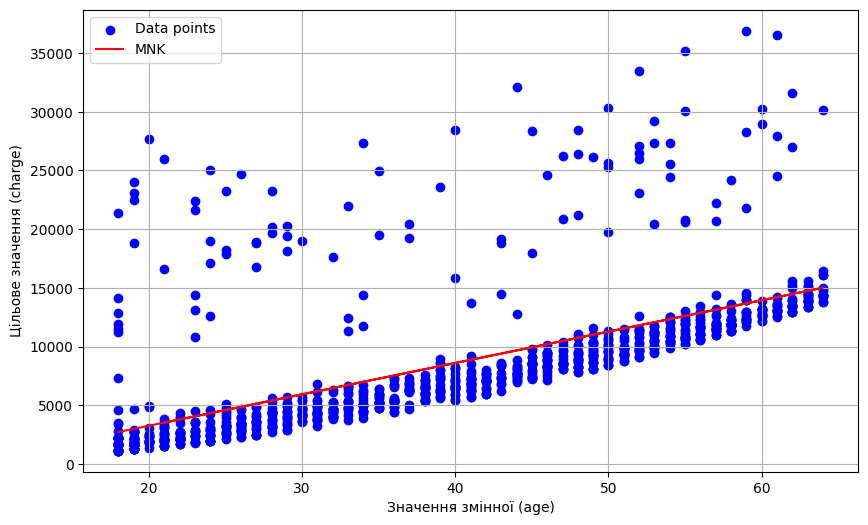

In [183]:
# Візуалізація результатів
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, predictions_MNK, color='red', label='MNK')
plt.xlabel('Значення змінної (age)')
plt.ylabel('Цільове значення (charge)')
plt.legend()
plt.grid(True)
plt.show()

In [184]:
r2 = r2_score(y, predictions_MNK)
rmse = root_mean_squared_error(y, predictions_MNK)
mae = mean_absolute_error(y, predictions_MNK)

print(f"R² score: {r2:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

R² score: 0.39
Root Mean Squared Error: 4662.51
Mean Absolute Error: 2580.52


### Завдання №1.2 (за допомогою Full-Batch градієнтного спуску)

In [185]:
# Градієнтний спуск
def full_batch_gradient_descent(X, y, lr=0.1, epochs=100):
    m, b = 0.0, 0.0  # Початкові параметри
    n = len(y)
    errors = []
    for _ in range(epochs):
        y_pred = m * X[:, 0] + b
        error = y_pred - y
        errors.append(sum(error**2))
        m_gradient = (2/n) * np.dot(error, X[:, 0])
        b_gradient = (2/n) * np.sum(error)

        m = m - lr * m_gradient
        b = b - lr * b_gradient

    return m, b, errors

220.15455551129122 0.2130065279986326


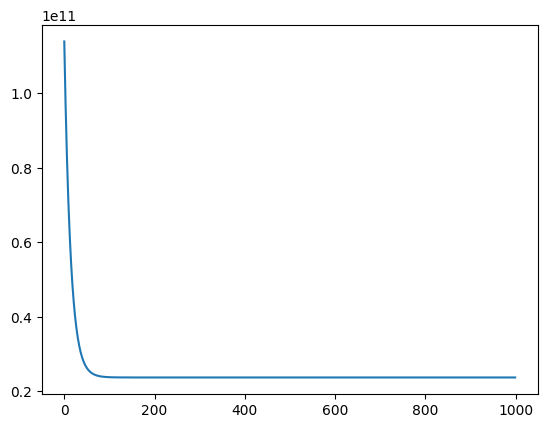

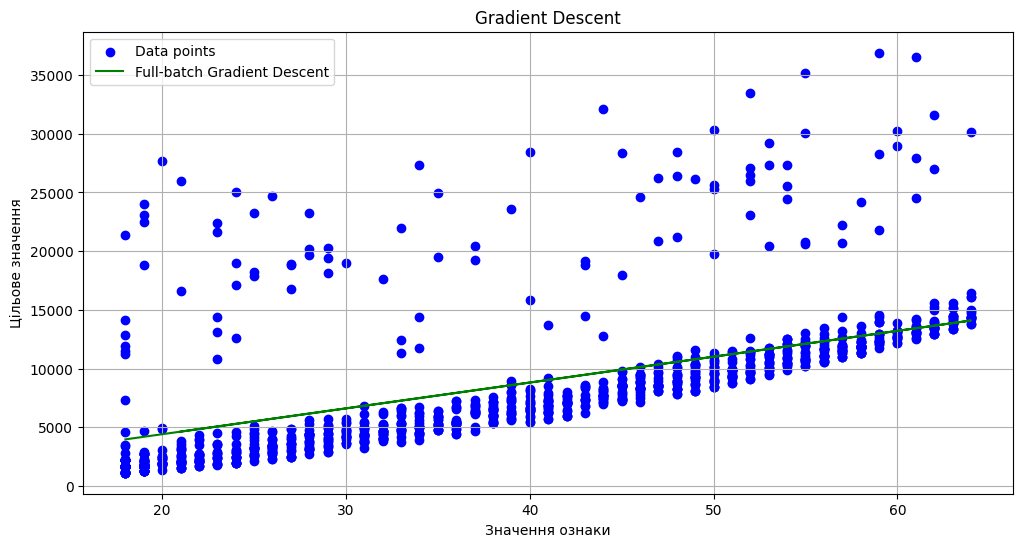

In [186]:
epochs = 1000
m, b, errors = full_batch_gradient_descent(X, y, lr=0.00001, epochs=epochs)
predictions_fbgd = m * X[:, 0] + b

print(m, b)

plt.plot(range(epochs), errors)

# Візуалізація результатів
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], y, color='blue', label='Data points')
plt.plot(X[:, 0], predictions_fbgd, color='green', label='Full-batch Gradient Descent')
plt.title('Gradient Descent')
plt.xlabel('Значення ознаки')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

In [187]:
r2 = r2_score(y, predictions_fbgd)
rmse = root_mean_squared_error(y, predictions_fbgd)
mae = mean_absolute_error(y, predictions_fbgd)

print(f"R² score: {r2:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

R² score: 0.38
Root Mean Squared Error: 4715.35
Mean Absolute Error: 2809.44


### Завдання №1.3 (за допомогою бібліотеки scikit-learn)

In [188]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [189]:
lin_reg.coef_, lin_reg.intercept_

(array([267.24891283]), np.float64(-2091.4205565650773))

In [190]:
predictions_sklearn = lin_reg.predict(X)

In [191]:
r2 = r2_score(y, predictions_sklearn)
rmse = root_mean_squared_error(y, predictions_sklearn)
mae = mean_absolute_error(y, predictions_sklearn)

print(f"R² score: {r2:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

R² score: 0.39
Root Mean Squared Error: 4662.51
Mean Absolute Error: 2580.52


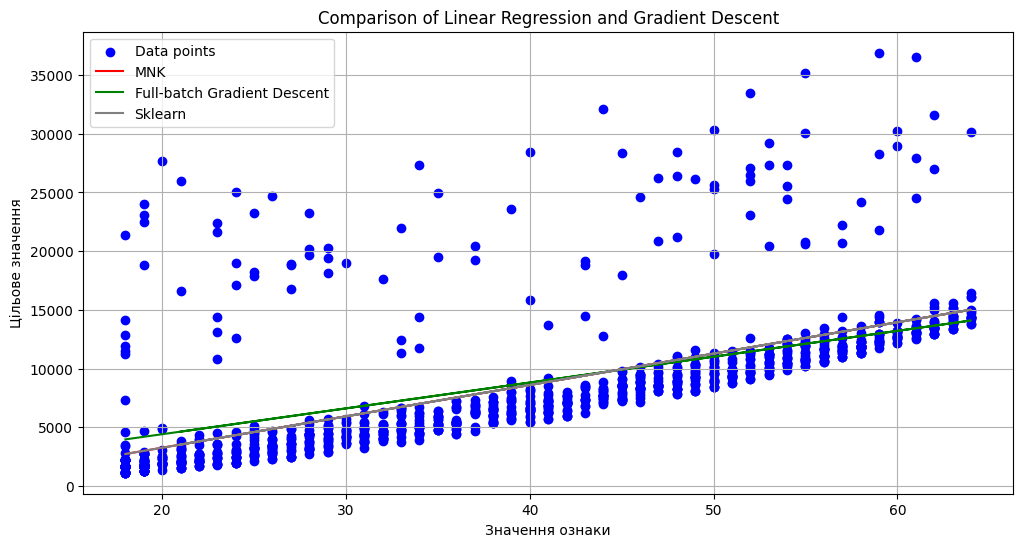

In [192]:
# Візуалізація результатів із трьох методів
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], y, color='blue', label='Data points')
plt.plot(X[:, 0], predictions_MNK, color='red', label='MNK')
plt.plot(X[:, 0], predictions_fbgd, color='green', label='Full-batch Gradient Descent')
plt.plot(X[:, 0], predictions_sklearn, color='gray', label='Sklearn')
plt.title('Comparison of Linear Regression and Gradient Descent')
plt.xlabel('Значення ознаки')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

# red and green lines are almost the same


**Висновки:**
- МНК, градієнтний спуск та бібліотека scikit-learn показали схожі результати. (вони перепитають майже на одній лінії)
- Знайдені параметри моделі близькі до моїх найкращих припущень.
- Із попереднього завдання у мене був наступний висновок:
> Найменше значення RMSE (4725.91) маємо при параметрах `w=300, b=-4000` із чотирьох спроб. Видно, що 2 останні параметри найкращі, бо ті прямі прям проходять ті дані.
Якщо тепер врахувати, що ми автоматично порахували через scikit-learn і отримати коефецієнт (array([267.24891283]), np.float64(-2091.4205565650773)), то можна сказати, що ці коефіцієнти дуже близькі до моїх найкращих припущень із попереднього завдання.
- В цілому всі три методи показали схожі результати. Але R2 score є близько до 0.38, що може означати, що немає сильної залежності між віком (варго взяти до уваги, що ми брали некурців тут) та вартістю медичних послуг як такої і скоріше за все є інші фактори, які впливають на цю залежність.

## **Завдання 2.**

Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [202]:
smoker_df = medical_df[medical_df.smoker == 'yes']
X = smoker_df.age.values.reshape(-1, 1)
y = smoker_df.charges.values

print(X.shape, y.shape)

lin_reg_smoker = LinearRegression()
lin_reg_smoker.fit(X, y)

predictions_smoker = lin_reg_smoker.predict(X)
print('Виводимо коефіцієнти моделі')
print(lin_reg_smoker.coef_, lin_reg_smoker.intercept_)

(274, 1) (274,)
Виводимо коефіцієнти моделі
[305.23760211] 20294.12812691597


In [200]:
r2 = r2_score(y, predictions_smoker)
rmse = root_mean_squared_error(y, predictions_smoker)
mae = mean_absolute_error(y, predictions_smoker)

print(smoker_df.charges.describe())
print('============================')
print(f"R² score: {r2:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")


count      274.000000
mean     32050.231832
std      11541.547176
min      12829.455100
25%      20826.244213
50%      34456.348450
75%      41019.207275
max      63770.428010
Name: charges, dtype: float64
R² score: 0.14
Root Mean Squared Error: 10711.00
Mean Absolute Error: 10097.80


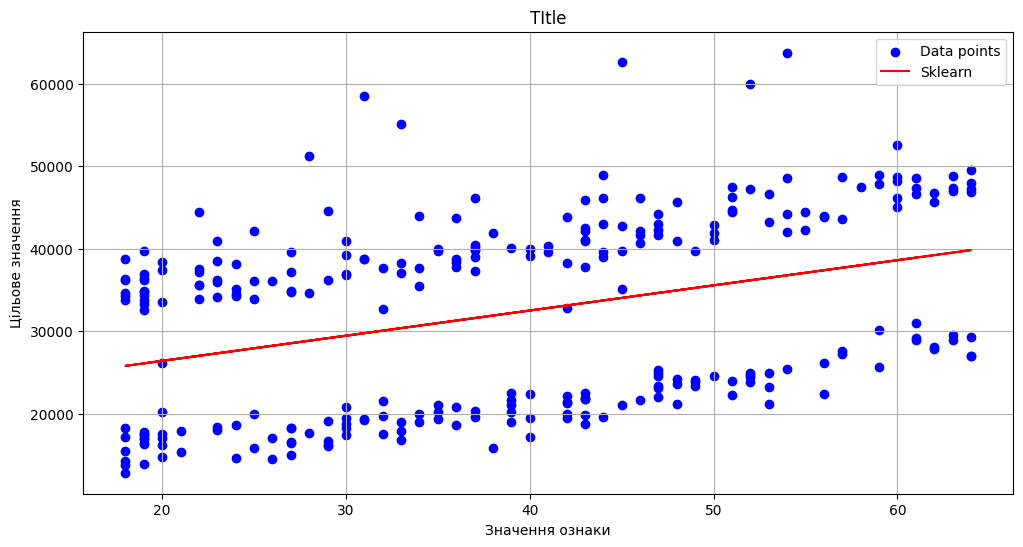

In [204]:
# Візуалізація результатів із трьох методів
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], y, color='blue', label='Data points')
plt.plot(X[:, 0], predictions_smoker, color='red', label='Sklearn')
plt.title('TItle')
plt.xlabel('Значення ознаки')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

# red and green lines are almost the same


**Висновки:**
- Модель показала досить низьку точність (R2 = 0.14), що може означати, що вік не є головним фактором, який впливає на вартість медичних послуг для курців.
- Root Mean Squared Error є досить великим (10711), коли std вартості медичних послуг для курців дорівнює 11541. Це означає, що наша модель не дуже точно передбачає вартість медичних послуг для курців.
- Модель не є досить точною, бо вона не проходить по усім точкам. Звичайно, що ми вчимось на лінійній регресії, тому поки тут такий результат.
- На графіку видно чітко дві групи точок, які варто точніше дослідити, що саме впливає на той чи інший результат.

Загальний висновок - ця модель не є досить точною, щоб використовувати її в компанії. Відхиляємо використання цієї моделі в компанії 😅
